# 0. Preps

### 0.1 Load modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
import brewer2mpl
import seaborn as sns
bmap = brewer2mpl.get_map('Paired', 'qualitative', 8)
colors = bmap.mpl_colors

### 0.2 Pre-set parameters for plotting

In [2]:
plt.rcParams.update({
    "font.weight": "normal",
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "lines.color": "k",
    "axes.titlesize": 18,
    "axes.titleweight": "normal",
    "axes.labelweight": "bold",
    "axes.labelsize": 18,
    "contour.linewidth": 0.8,
    "legend.fontsize": 14
})

### 0.3 Plotting functions

In [3]:
def basic_plot(time,var,varM,label,xi,v_file,depth=False):
    '''
    This function plots a chosen variable as a function of time,
    and, in addition, the variable's mean.
    _____________________________________________________________________
    
    time   ---> distance along x-axis
    var    ---> chosen variable 
    varM   ---> mean of chosen variable
    label  ---> specify label for legend
    xi     ---> location of cross-section
    v_file ---> specify if 2D or 3D velocity file
    _____________________________________________________________________
    '''
    sns.set()
    fig, ax  = plt.subplots(figsize=(6,4))                                                # plot fig with one subplot
    ax.plot  (time,var,label=label,color=colors[0],lw=4)                                  # plot the chosen variable as fct of time
    ax.hlines(varM,xmin=time[0],xmax=time[-1],label='mean '+label,color=colors[1],lw=4)   # plot the mean of the chosen variable
    ax.legend(loc=1)                                                                      # add legend and specify its location
    if depth==False:
        ax.set(title='Cross-section at i = '+str(xi/1000)+' km; '+v_file,xlabel='time [s]',ylabel='[m]')
    if depth==True:
        ax.set(title='Cross-section at i = '+str(xi/1000)+' km',xlabel='time [s]',ylabel='[m]')

# 1. Load file with resolved tidal data

In [4]:
path_file = '/home/henell/WORK/tools/GETM/setups/warner/warner.3d.nc'    # location of file
id_file   = netCDF4.Dataset(path_file, 'r')                              # read file

In [5]:
# print dimension of all variables in file
list_var = id_file.variables.keys()
print('\n Variables in the files:')
for cvar in list_var:
    nb_dim = len(id_file.variables[cvar].dimensions)
    print(' *** '+cvar+' -> has '+str(nb_dim)+' dimensions')
print('')


 Variables in the files:
 *** grid_type -> has 0 dimensions
 *** vert_cord -> has 0 dimensions
 *** ioff -> has 0 dimensions
 *** joff -> has 0 dimensions
 *** dx -> has 0 dimensions
 *** dy -> has 0 dimensions
 *** xc -> has 1 dimensions
 *** yc -> has 1 dimensions
 *** sigma -> has 1 dimensions
 *** bathymetry -> has 2 dimensions
 *** time -> has 1 dimensions
 *** elev -> has 3 dimensions
 *** u -> has 3 dimensions
 *** v -> has 3 dimensions
 *** hcc -> has 3 dimensions
 *** uu -> has 4 dimensions
 *** vv -> has 4 dimensions
 *** w -> has 4 dimensions
 *** salt -> has 4 dimensions
 *** sigma_t -> has 4 dimensions



In [6]:
i = 45 ; j = 0

In [7]:
time  = id_file.variables['time'][1:]         # [s]; exclude initial tidal snapshot (avoid double-counting during tidal averaging)
dx    = id_file.variables['dx'][:]            # grid spacing (x) [m]
dy    = id_file.variables['dy'][:]            # grid spacing (y) [m]
salt  = id_file.variables['salt'][1:,:,j,i]   # salinity [gkg-1]

### Analyze water depth

In [8]:
xcl = id_file.variables['xc'][i]                  # xc [m] @ center of the cell (LHS) 
xcr = id_file.variables['xc'][i+1]                # xc [m] @ center of the cell (RHS)
xi  = 0.5 * ( xcl + xcr )                         # average to U-point interface between center cells
print( '\n Analyze cross-section ',
      xi/1000, ' km upstream of open boundary.' )


 Analyze cross-section  22.5  km upstream of open boundary.


In [9]:
bathyl = id_file.variables['bathymetry'][j,i]    # bathymetry (H) [m] @ center of the cell (LHS) 
bathyr = id_file.variables['bathymetry'][j,i+1]  # bathymetry (H) [m] @ center of the cell (RHS) 
bathyi = 0.5 * ( bathyl + bathyr )               # average to U-point interface between center cells

In [10]:
elevl = id_file.variables['elev'][:,j,i]                             # elevation (eta) [m] @ center of the cell (LHS) 
elevr = id_file.variables['elev'][:,j,i+1]                           # elevation (eta) [m] @ center of the cell (RHS) 
elevi = 0.25 * ( elevl[:-1] + elevl[1:] + elevr[:-1] + elevr[1:] )   # average in space and time

In [11]:
sigma = id_file.variables['sigma'][:]         # depth in sigma coordinates
(Nt, Nk) = np.shape(salt)

In [12]:
# calculate vertical layer thickness
h = np.empty( (Nt, Nk) )
for t in range(Nt):
    for k in range(1,Nk):
         h[t,k] = ( sigma[k] - sigma[k-1] ) * ( bathyi + elevi[t] )
h

array([[4.04738577e-320, 3.14072973e-001, 3.14072973e-001, ...,
        3.14072973e-001, 3.14072973e-001, 3.14072973e-001],
       [4.03179200e-313, 3.14862242e-001, 3.14862242e-001, ...,
        3.14862242e-001, 3.14862242e-001, 3.14862242e-001],
       [4.94065646e-324, 3.15660616e-001, 3.15660616e-001, ...,
        3.15660616e-001, 3.15660616e-001, 3.15660616e-001],
       ...,
       [0.00000000e+000, 3.11809015e-001, 3.11809015e-001, ...,
        3.11809015e-001, 3.11809015e-001, 3.11809015e-001],
       [0.00000000e+000, 3.12552736e-001, 3.12552736e-001, ...,
        3.12552736e-001, 3.12552736e-001, 3.12552736e-001],
       [0.00000000e+000, 3.13308594e-001, 3.13308594e-001, ...,
        3.13308594e-001, 3.13308594e-001, 3.13308594e-001]])

In [13]:
# calculate zw, the depth in z coordinates, based on h
zw = np.zeros_like(h, subok=False)
zw[:,:] = np.cumsum(h[:,:], axis=1)
zw = zw - bathyi
zw

array([[-12.75      , -12.43592703, -12.12185405, ...,  -0.81522702,
         -0.50115404,  -0.18708107],
       [-12.75      , -12.43513776, -12.12027552, ...,  -0.78523479,
         -0.47037255,  -0.15551031],
       [-12.75      , -12.43433938, -12.11867877, ...,  -0.75489658,
         -0.43923596,  -0.12357534],
       ...,
       [-12.75      , -12.43819098, -12.12638197, ...,  -0.90125742,
         -0.5894484 ,  -0.27763939],
       [-12.75      , -12.43744726, -12.12489453, ...,  -0.87299602,
         -0.56044328,  -0.24789055],
       [-12.75      , -12.43669141, -12.12338281, ...,  -0.84427344,
         -0.53096485,  -0.21765625]])

In [14]:
#zx = ( zw[:,:-1] + zw[:,1:] ) / 2
#zx[:,0] = zw[:,1]
#zx[:,-1] = zw[:,-2]
#zx

In [15]:
Di      = bathyi + elevi     # time-varying water depth
Di_mean = Di.mean()          # mean water depth

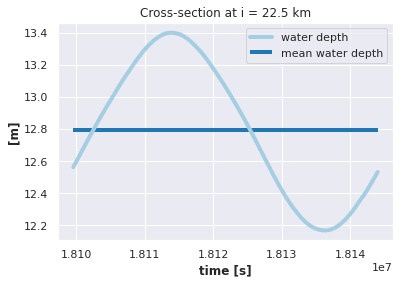

In [16]:
basic_plot(time,Di,Di_mean,'water depth',xi,'u2D',depth=True)

### Analyze depth-averaged velocity

In [17]:
u2d      = id_file.variables[ 'u'][1:,j,i]                    # time-varying depth-averaged velocity [m/s]
u2d_mean = u2d.mean()                                         # mean depth-averaged velocity [m/s]
print( 'Mean depth-averaged velocity is <u2d> =', u2d_mean )

Mean depth-averaged velocity is <u2d> = -0.01744917


In [18]:
u3d            = id_file.variables['uu'][1:,:,j,i]                   # time- and depth-varying velocity [m/s]
u3d_mean_ik    = u3d.mean(axis=1)                                    # time-varying depth-averaged velocity [m/s]
u3d_mean_ik_it = u3d_mean_ik.mean(axis=0)                            # mean depth-averaged velocity [m/s]
print( 'Mean depth-averaged velocity is <u3d> =', u3d_mean_ik_it )

Mean depth-averaged velocity is <u3d> = -0.017447778868622005


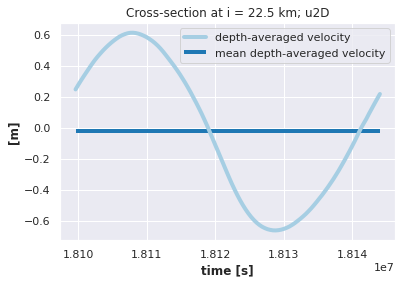

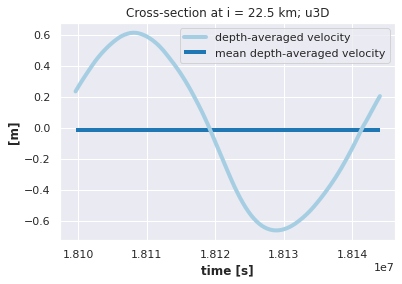

In [19]:
basic_plot(time,u2d,u2d_mean,'depth-averaged velocity',xi,'u2D')
basic_plot(time,u3d_mean_ik,u3d_mean_ik_it,'depth-averaged velocity',xi,'u3D')

### Analyze depth-integrated transport

#### First guesses

#### u2D

In [20]:
Di_mean_u2d_mean = Di_mean * u2d_mean                                            # mean depth-integrated transport from 2D u-field
print( 'First guess for mean depth-integrated transport is dy*<D>*<u2d> = ',
      dy*Di_mean_u2d_mean )

First guess for mean depth-integrated transport is dy*<D>*<u2d> =  -111.63073033094406


#### u3D

In [21]:
Di_mean_u3d_mean = Di_mean * u3d_mean_ik_it                                      # mean depth-integrated transport from 3D u-field
print( 'First guess for mean depth-integrated transport is dy*<D>*<u3d> = ',
      dy*Di_mean_u3d_mean )

First guess for mean depth-integrated transport is dy*<D>*<u3d> =  -111.62182486786821


In [22]:
h_mean = np.mean(h.mean(axis=1))
h_mean_u3d_mean = h_mean * u3d_mean_ik_it                                      # mean depth-integrated transport from 3D u-field
print( 'First guess for mean depth-integrated transport is dy*<h>*<u3d> = ',
      dy*h_mean_u3d_mean )

First guess for mean depth-integrated transport is dy*<h>*<u3d> =  -2.722483659811219


In [23]:
z_mean = np.mean(zw.mean(axis=1))
z_mean_u3d_mean = z_mean * u3d_mean_ik_it                                      # mean depth-integrated transport from 3D u-field
print( 'First guess for mean depth-integrated transport is dy*<z>*<u3d> = ',
      dy*z_mean_u3d_mean )

First guess for mean depth-integrated transport is dy*<z>*<u3d> =  55.418675261335245


### Taking the mean over the mean depth/vertical layer thickness times the velocity

#### u2D

In [24]:
Du2d      = Di * u2d                                                             # time-varying depth-integrated transport from 2D u-field
Du2d_mean = Du2d.mean()                                                          # mean depth-integrated transport from 2D u-field
print( 'Mean depth-integrated transport is dy * < D * u2d > =',
      dy*Du2d_mean )

Mean depth-integrated transport is dy * < D * u2d > = -51.95033550262451


#### u3D

In [25]:
Du3d      = Di * u3d_mean_ik_it                                                  # time-varying depth-integrated transport from 3D u-field
Du3d_mean = Du3d.mean()                                                          # mean depth-integrated transport from 3D u-field
print( 'Mean depth-integrated transport is dy*<D*u3d> =', dy*Du3d_mean )

Mean depth-integrated transport is dy*<D*u3d> = -111.62183433771133


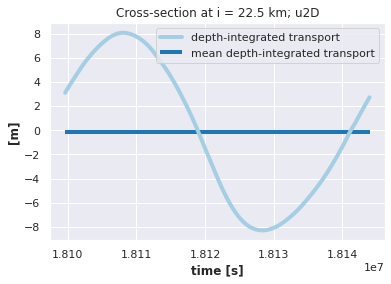

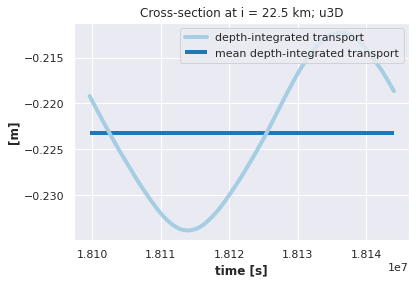

In [26]:
basic_plot(time,Du2d,Du2d_mean,'depth-integrated transport',xi,'u2D')
basic_plot(time,Du3d,Du3d_mean,'depth-integrated transport',xi,'u3D')

### Define mean transport velocity

#### u2D

In [27]:
u2d_twa = Du2d_mean / Di_mean
print( 'Mean depth-integrated transport velocity is <D*u2d>/<D> =', u2d_twa )
print( 'Mean depth-averaged velocity is <u2d> =', u2d_mean )

Mean depth-integrated transport velocity is <D*u2d>/<D> = -0.008120437
Mean depth-averaged velocity is <u2d> = -0.01744917


#### u3D

In [28]:
u3d_twa = Du3d_mean / Di_mean
print( 'Mean depth-integrated transport velocity is <D*u3d>/<D> =', u3d_twa )
print( 'Mean depth-averaged velocity is <u3d> =', u3d_mean_ik_it )

Mean depth-integrated transport velocity is <D*u3d>/<D> = -0.01744778
Mean depth-averaged velocity is <u3d> = -0.017447778868622005


### 1$^{st}$ guess for Qin and Qout

#### u2D

In [29]:
Du2d_in       =  np.fmax( 0 , Du2d ) # only consider positive transports
Du2d_out      = -np.fmin( Du2d , 0 ) # only consider negative transports
Du2d_in_mean  = Du2d_in.mean()
Du2d_out_mean = Du2d_out.mean()
print( 'First guess for Qin is dy*<(D*u2d)^+> =', dy*Du2d_in_mean )
print( 'First guess for Qout is -dy*<(D*u2d)^-> =', dy*Du2d_out_mean )

First guess for Qin is dy*<(D*u2d)^+> = 1272.9873657226562
First guess for Qout is -dy*<(D*u2d)^-> = 1324.9376841953822


#### u3D

In [30]:
Du3d_in       =  np.fmax( 0 , Du3d ) # only consider positive transports
Du3d_out      = -np.fmin( Du3d , 0 ) # only consider negative transports
Du3d_in_mean  = Du3d_in.mean()
Du3d_out_mean = Du3d_out.mean()
print( 'First guess for Qin is dy*<(D*u3d)^+> =', dy*Du3d_in_mean )
print( 'First guess for Qout is -dy*<(D*u3d)^-> =', dy*Du3d_out_mean )

First guess for Qin is dy*<(D*u3d)^+> = 0.0
First guess for Qout is -dy*<(D*u3d)^-> = 111.62183114460537


### Check volume balance

In [31]:
t0     = id_file.variables['time'][ 0]
t1     = id_file.variables['time'][-1]
bathy1 = id_file.variables['bathymetry'][j,i+1:]
elev0  = id_file.variables['elev'][ 0,j,i+1:]
elev1  = id_file.variables['elev'][-1,j,i+1:]
D0     = bathy1 + elev0
D1     = bathy1 + elev1
V0     = D0.sum() * dx * dy
V1     = D1.sum() * dx * dy
print(' dV/dt =', ( V1 - V0 ) / ( t1 - t0 ) )
print(' Qin - Qout + Qr =', dy * ( Du2d_in_mean - Du2d_out_mean ) + 50 )  #### u2D
print(' Qin - Qout + Qr =', dy * ( Du3d_in_mean - Du3d_out_mean ) + 50 )  #### u3D

 dV/dt = 0.039201612318200726
 Qin - Qout + Qr = -1.950318472725911
 Qin - Qout + Qr = -61.621831144605366


==> Slightly non-periodic state dV/dt<>0 (could be avoided by averaging over more tidal cycles) !!!  
==> Volume balance is ok (single precision errors can be avoided with `-D_NCDF_SAVE_DOUBLE_`) !!!